In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("orvile/isles-2022-brain-stoke-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/isles-2022-brain-stoke-dataset


Found 250 cases. Initializing generator...
Fetching and visualizing the first randomized batch...


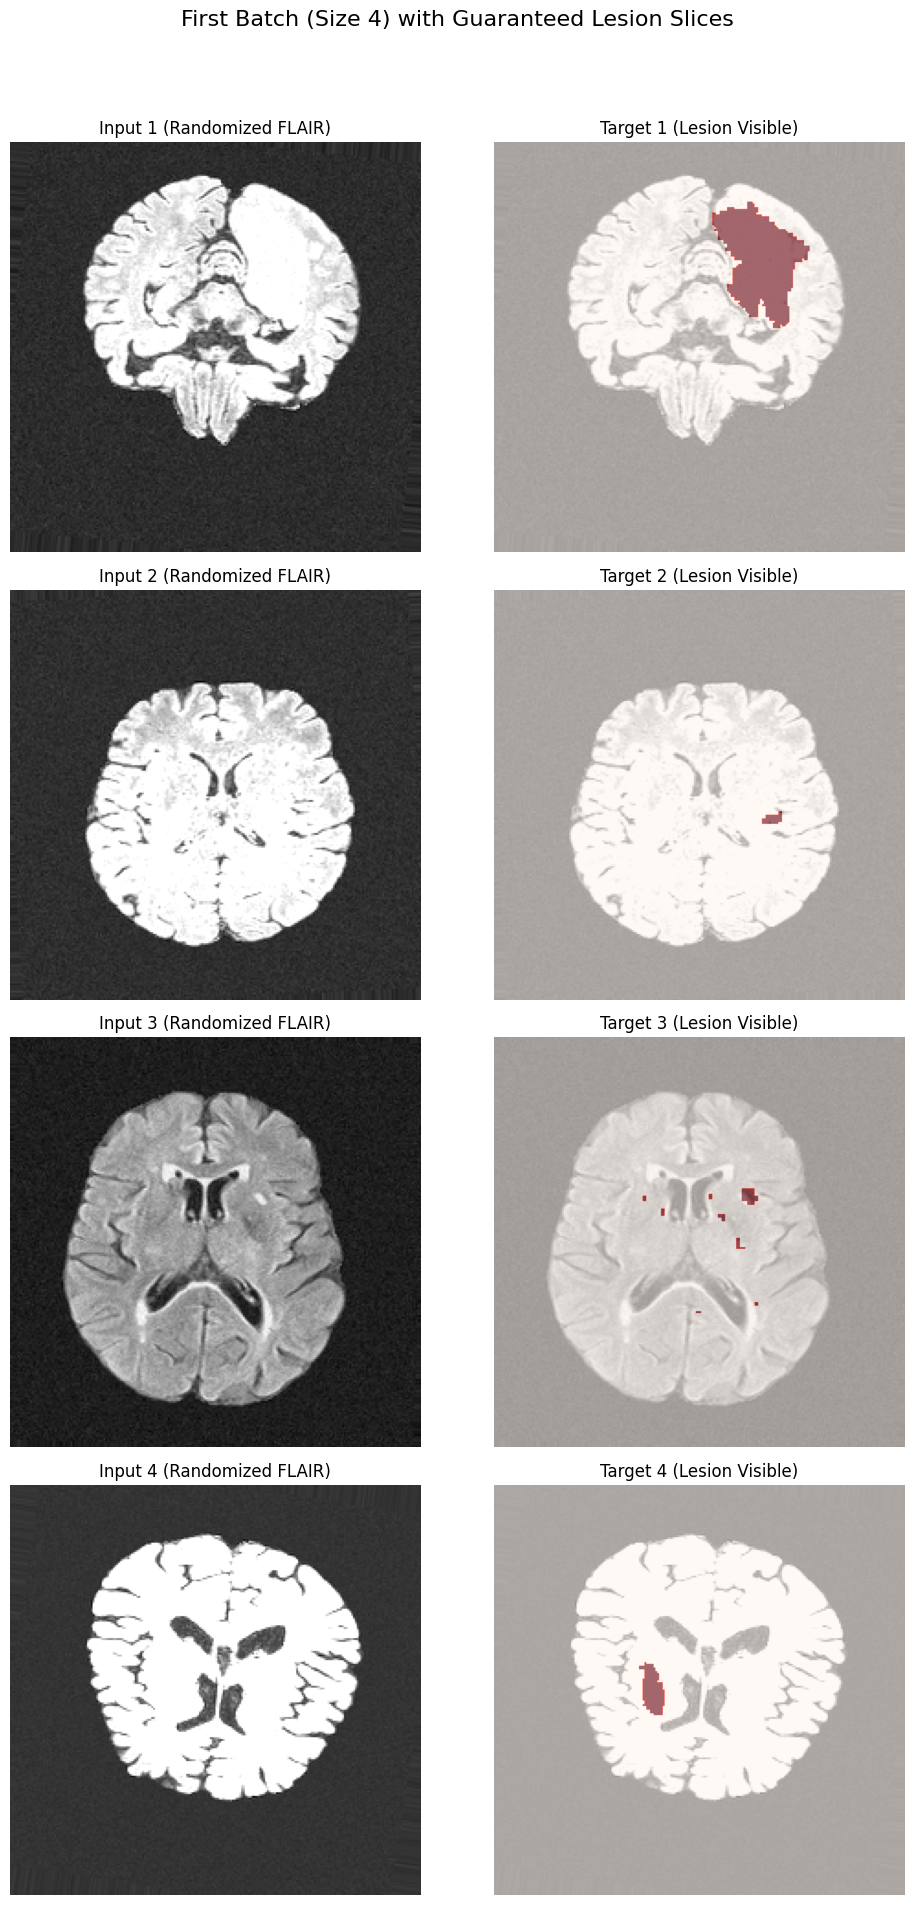

Batch shapes: Input (X): (4, 224, 224, 1), Target (Y): (4, 224, 224, 1)


In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from nibabel.processing import resample_from_to
from tensorflow.keras.utils import Sequence
# ADDED: Import for efficient N-D array resizing
from scipy.ndimage import zoom, rotate
# --- Configuration Constants ---
BASE_DIR = "/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022"
DERIVATIVES_DIR = os.path.join(BASE_DIR, "derivatives")
SESSION_ID = "ses-0001"
IMG_SIZE = (224, 224) # Target size for a common model input
BATCH_SIZE = 4       # Small batch size for visualization

# --- Helper Function for Resizing (Fix for plt.resize error) ---

def resize_slice(data, new_size, is_mask=False):
    """
    Resizes a 2D numpy array using scipy.ndimage.zoom.
    """
    current_h, current_w = data.shape
    target_h, target_w = new_size
    
    # Calculate zoom factors
    zoom_factors = (target_h / current_h, target_w / current_w)
    
    # Order=3 (cubic) for image; Order=0 (nearest neighbor) for labels
    interpolation_order = 0 if is_mask else 3
    
    # The actual resizing function
    resized_data = zoom(data, zoom_factors, order=interpolation_order)
    
    return resized_data


# --- 1. Generator Class for NIfTI Domain Randomization ---

class KaggleNiftiGenerator(Sequence):
    """
    Keras Sequence for CPU-friendly 3D NIfTI data loading, resampling, and Domain Randomization (DR).
    """
    def __init__(self, case_ids, base_dir, derivatives_dir, session_id, img_size, batch_size):
        self.case_ids = case_ids
        self.base_dir = base_dir
        self.derivatives_dir = derivatives_dir
        self.session_id = session_id
        self.img_size = img_size
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.floor(len(self.case_ids) / self.batch_size))

    def on_epoch_end(self):
        """Updates case_ids after each epoch (shuffling for next epoch)."""
        random.shuffle(self.case_ids)

    def _load_and_process_volume(self, case_id):
        """Loads, resamples, and extracts a 2D slice from one NIfTI pair."""
        
        # Construct paths
        flair_path = os.path.join(self.base_dir, case_id, self.session_id, "anat", f"{case_id}_{self.session_id}_FLAIR.nii")
        mask_path = os.path.join(self.derivatives_dir, case_id, self.session_id, f"{case_id}_{self.session_id}_msk.nii")

        # Load images
        flair_img = nib.load(flair_path)
        mask_img = nib.load(mask_path)
        
        # Resample mask to FLAIR space
        resampled_mask = resample_from_to(mask_img, flair_img, order=0) # order=0 is nearest neighbor

        # Get data and normalize FLAIR
        flair_data = flair_img.get_fdata().astype(np.float32)
        mask_data = resampled_mask.get_fdata().astype(np.float32)
        
        # Intensity Normalization (basic Z-score/Clip)
        flair_data = (flair_data - np.mean(flair_data)) / (np.std(flair_data) + 1e-6)
        flair_data = np.clip(flair_data, -3, 3) / 6.0 + 0.5 # Scale to ~[0, 1]

        # *** FIX: Find an active slice index *** (Same logic as last response)
        max_slice = flair_data.shape[2] - 1
        min_z = int(max_slice * 0.2)
        max_z = int(max_slice * 0.8)
        
        mask_sums = mask_data[:, :, min_z:max_z].sum(axis=(0, 1))
        lesion_slice_indices = np.where(mask_sums > 0)[0] 
        
        if len(lesion_slice_indices) > 0:
            random_offset = random.choice(lesion_slice_indices)
            slice_idx = min_z + random_offset
        else:
            slice_idx = random.randint(min_z, max_z) # Fallback

        X_slice = flair_data[:, :, slice_idx]
        Y_slice = mask_data[:, :, slice_idx]
        # CORRECTED: Resize to target size using the helper function
        X_slice = resize_slice(X_slice, self.img_size, is_mask=False)
        Y_slice = resize_slice(Y_slice, self.img_size, is_mask=True) # order=0 is crucial for masks

        return X_slice, Y_slice

    def _apply_domain_randomization(self, img, mask):
        """Applies 2D image-level domain randomization on a slice."""
        
        # --- 1. Intensity Randomization (Unchanged) ---
        alpha = random.uniform(0.8, 1.2) # Contrast
        beta = random.uniform(-0.1, 0.1) # Brightness
        img = img * alpha + beta
        noise_level = random.uniform(0.005, 0.02)
        noise = np.random.normal(0, noise_level, img.shape)
        img += noise
        
        # --- 2. Geometric Randomization (MODIFIED) ---
        
        # a) Random Flip (Unchanged)
        if random.random() < 0.5:
            img = np.fliplr(img)
            mask = np.fliplr(mask)
        
        # b) Realistic Slight Rotation (NEW)
        # Select a small, random angle between -10 and +10 degrees
        angle = random.uniform(-10.0, 10.0) 

        if abs(angle) > 0.1:
            # Rotate image using spline interpolation (order=3)
            # reshape=False ensures the output image size remains the same (clipping)
            img = rotate(img, angle, reshape=False, order=3, mode='nearest')

            # Rotate mask using nearest neighbor interpolation (order=0) to preserve label integrity
            mask = rotate(mask, angle, reshape=False, order=0, mode='nearest')

        # Final cleanup
        img = np.clip(img, 0, 1)
        mask = (mask > 0).astype(np.float32) # Ensure mask is strictly binary after rotation interpolation

        return img, mask

    def __getitem__(self, index):
        """Generate one batch of data."""
        
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_case_ids = self.case_ids[start_idx:end_idx]
        
        X = np.empty((len(batch_case_ids), *self.img_size, 1), dtype=np.float32)
        Y = np.empty((len(batch_case_ids), *self.img_size, 1), dtype=np.float32)

        for i, case_id in enumerate(batch_case_ids):
            try:
                X_slice, Y_slice = self._load_and_process_volume(case_id)
                
                # Apply Domain Randomization
                if random.random() < 0.5:  # 50% chance to apply DR
                    X_slice_dr, Y_slice_dr = self._apply_domain_randomization(X_slice, Y_slice)
                    X[i, :, :, 0] = X_slice_dr
                    Y[i, :, :, 0] = Y_slice_dr
                else:
                    X[i, :, :, 0] = X_slice
                    Y[i, :, :, 0] = Y_slice

                
            except Exception as e:
                # Handle corrupted/missing files gracefully
                print(f"Error processing {case_id}: {type(e).__name__}: {e}. Replacing with blank data.")
                X[i, :, :, 0] = np.zeros(self.img_size)
                Y[i, :, :, 0] = np.zeros(self.img_size)

        return X, Y


# --- 2. Setup and Visualization ---

# Identify all subject folders 
try:
    subject_cases = [d for d in os.listdir(BASE_DIR) if d.startswith("sub-strokecase")]
    if not subject_cases:
        print(f"Error: No subject folders found in {BASE_DIR}. Check paths.")
        exit()
except FileNotFoundError as e:
    print(f"Error accessing directory: {e}. Check mounting.")
    exit()

print(f"Found {len(subject_cases)} cases. Initializing generator...")

# Initialize the generator
data_generator = KaggleNiftiGenerator(
    case_ids=subject_cases,
    base_dir=BASE_DIR,
    derivatives_dir=DERIVATIVES_DIR,
    session_id=SESSION_ID,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# --- 3. Visualize the First Domain-Randomized Batch --

print("Fetching and visualizing the first randomized batch...")
# Get the first batch (index 0)
X_batch, Y_batch = data_generator[0]

fig, axes = plt.subplots(BATCH_SIZE, 2, figsize=(10, 5 * BATCH_SIZE))
fig.suptitle(f"First Batch (Size {BATCH_SIZE}) with Guaranteed Lesion Slices", fontsize=16)

for i in range(BATCH_SIZE):
    # Image (Input)
    ax_img = axes[i, 0]
    ax_img.imshow(X_batch[i, :, :, 0].T, cmap="gray", origin="lower")
    ax_img.set_title(f"Input {i+1} (Randomized FLAIR)")
    ax_img.axis("off")

    # Mask (Target)
    ax_mask = axes[i, 1]
    ax_mask.imshow(X_batch[i, :, :, 0].T, cmap="gray", origin="lower") # Show base image
    
    # *** VISUALIZATION FIX: Use simple plt.imshow for overlay ***
    # This uses the mask values directly, relying on the 'Reds' cmap to handle non-zero values 
    # and the overall figure alpha/background to handle zeros.
    mask_to_plot = Y_batch[i, :, :, 0].T 
    ax_mask.imshow(mask_to_plot, cmap="Reds", alpha=0.6, origin="lower")
    
    # Check if a lesion was actually found for this plot
    lesion_status = "Lesion Visible" if np.sum(mask_to_plot) > 0 else "No Lesion in Slice"
    ax_mask.set_title(f"Target {i+1} ({lesion_status})")
    ax_mask.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"Batch shapes: Input (X): {X_batch.shape}, Target (Y): {Y_batch.shape}")